In [7]:
! pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
! pip install seaborn
import seaborn as sns
import networkx as nx

DEPRECATION: Loading egg at /home/gulce/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pydensecrf-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /home/gulce/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pydensecrf-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


###  Uniformly Sampling DAGs
Talvitie and Koivisto 

Generates a random permutation of the nodes to establish an ordering.

This ordering ensures acyclicity since edges are only added from earlier nodes to later nodes.

For each node (except the first), we consider all previous nodes in the ordering as potential parents.

We randomly choose a number of parents for the current node, uniformly between 0 and max_parents (or the number of possible parents).

Parents are selected uniformly at random from the possible parents

By uniformly selecting the number of parents and the parents themselves, we ensure that each possible DAG has an equal probability of being sampled under the constraints.

In [10]:

def sample_uniform_dag(num_nodes, max_parents=None):
    nodes = list(range(num_nodes))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    
   
    ordering = np.random.permutation(nodes)
    
    for i in range(1, num_nodes):
        current_node = ordering[i]
        possible_parents = ordering[:i]
        

        if max_parents is not None:
            max_p = min(len(possible_parents), max_parents)
        else:
            max_p = len(possible_parents)
        
        num_parents = np.random.randint(0, max_p + 1)
        
        parents = np.random.choice(possible_parents, size=num_parents, replace=False)

        for parent in parents:
            G.add_edge(parent, current_node)
    
    return G

In [11]:
num_nodes =  8 # Number of nodes in the DAG
max_parents = 4  # Maximum number of parents per node (optional)
N = 10000  # Number of data samples to generate
alpha = 1.0  # Dirichlet parameter (uniform prior)

In [12]:
node_states = {node: [0, 1] for node in range(num_nodes)}
    
# G is my model 
G = sample_uniform_dag(num_nodes, max_parents=max_parents)

In [13]:
import itertools
import pandas as pd
def sample_theta_given_g(G, node_states, alpha=1.0):
    theta = {}
    nodes = list(nx.topological_sort(G))
    for node in nodes:
        parents = list(G.predecessors(node))
        node_state_space = node_states[node]
        num_node_states = len(node_state_space)
        
        if len(parents) == 0:
           
            alpha_vector = np.full(num_node_states, alpha)
            probabilities = np.random.dirichlet(alpha_vector)
            theta[node] = {}
            theta[node][()] = probabilities  
        else:
            
            parent_states = [node_states[parent] for parent in parents]
            parent_configurations = list(itertools.product(*parent_states))
            theta[node] = {}
            for parent_config in parent_configurations:
                # Sample Dirichlet 
                alpha_vector = np.full(num_node_states, alpha)
                probabilities = np.random.dirichlet(alpha_vector)
                theta[node][parent_config] = probabilities
    return theta

In [14]:
theta = sample_theta_given_g(G, node_states, alpha=alpha )# p(theta|G)

In [15]:
def generate_data(G, theta, node_states, N):
    nodes = list(nx.topological_sort(G))
    data = []
    for _ in range(N):
        sample = {}
        for node in nodes:
            parents = list(G.predecessors(node))
            if len(parents) == 0:
                # Sample from the prior distribution 
                probabilities = theta[node][()]
                node_value = np.random.choice(node_states[node], p=probabilities)
                sample[node] = node_value
            else:
                # Sample from the conditional distribution
                parent_values = tuple(sample[parent] for parent in parents)
                probabilities = theta[node][parent_values]
                node_value = np.random.choice(node_states[node], p=probabilities)
                sample[node] = node_value
        data.append(sample)
    return pd.DataFrame(data)

In [16]:
df = generate_data(G, theta, node_states, N)

In [17]:
plt.figure(figsize=(32, 24))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, arrowstyle='->', arrowsize=20)
plt.title("Uniformly Sampled Bayesian Network Structure (DAG)")
#plt.show()
plt.savefig("Uniformly Sampled Bayesian Network Structure (DAG")
plt.close()    

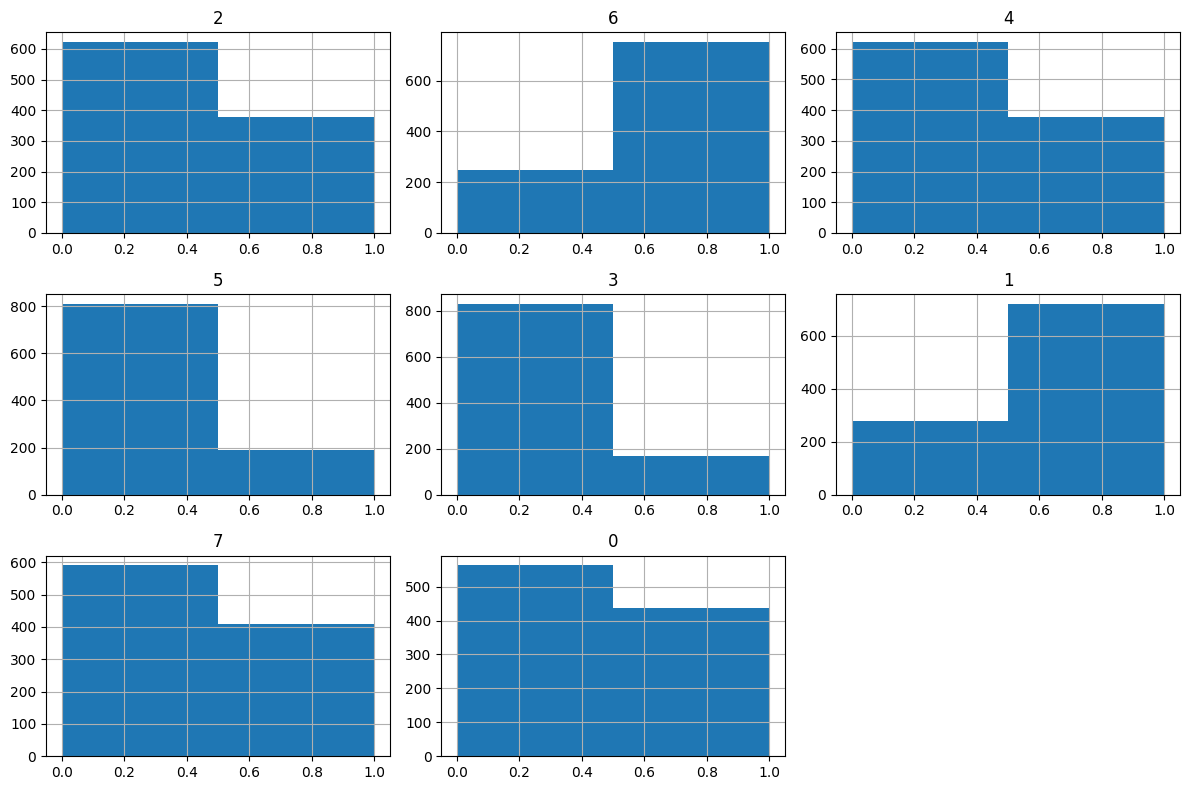

In [ ]:

df.hist(bins=2, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [20]:

# df = df.apply(lambda x: x.astype('category'))

columns = ['0', '1', '2', '3', '4', '5', '6', '7']
data = [[2] *( len(columns)+0)]  # Each column has an arity of 2

# Convert to DataFrame
df_arity = pd.DataFrame(data, columns=columns)
print(df.columns)
column_mapping = {old: new for old, new in zip(df.columns, df_arity.columns)}
df = df.rename(columns=column_mapping)

# Now, combine the data as before
df_combined_correct = pd.concat([df_arity, df], ignore_index=True)
df_combined_correct.to_csv("combined_dataset.csv", index=False)


# Combine the arity information (first row) with the rest of the dataset
df_combined_correct = pd.concat([df_arity, df])
# Save the DataFrame to a CSV file for inspection or future use
df_arity.to_csv("original_dataset.csv", index=False)
# Append the arity row (df_arity) on top of the data_samples
df_combined = pd.concat([df_arity, df], ignore_index=True)

# Save the combined dataset to a CSV file
df_combined.to_csv("combined_dataset.dat", index=False, sep=' ')



Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')


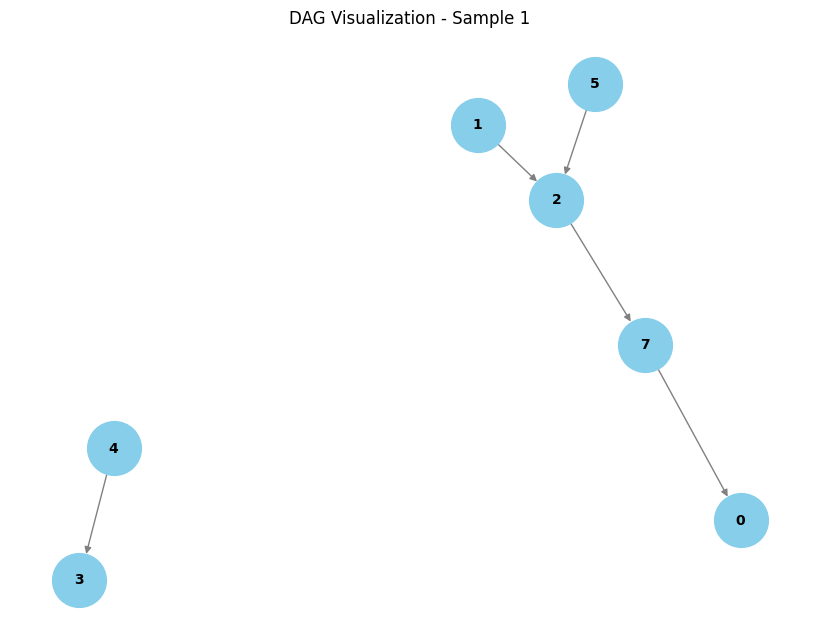

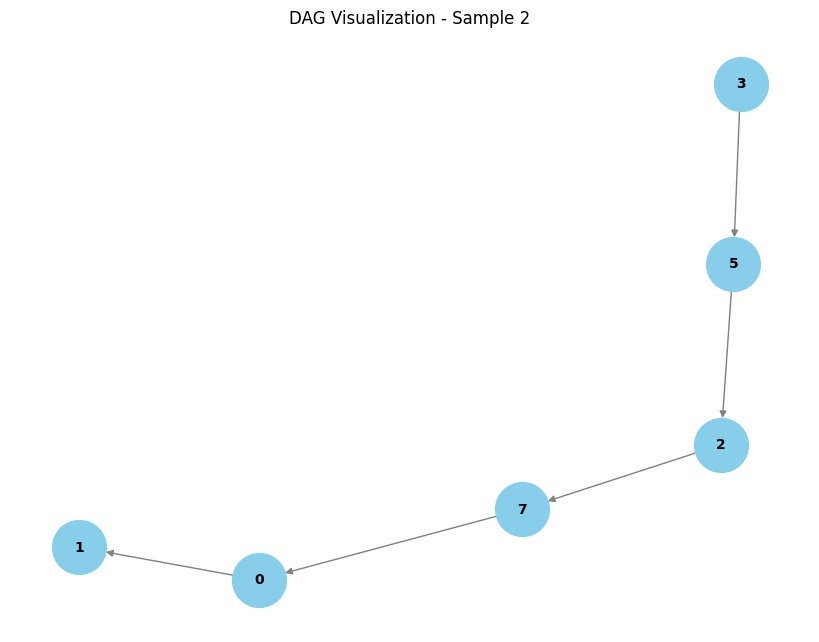

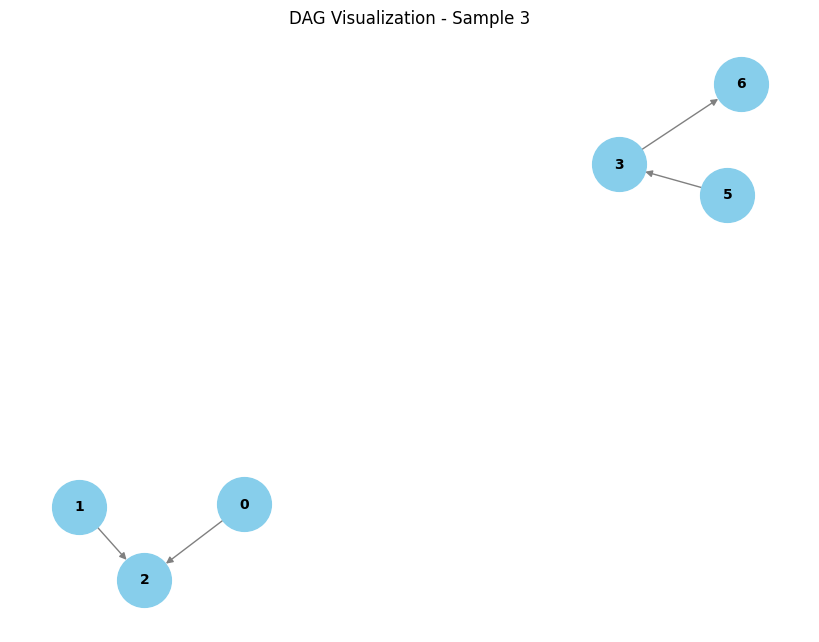

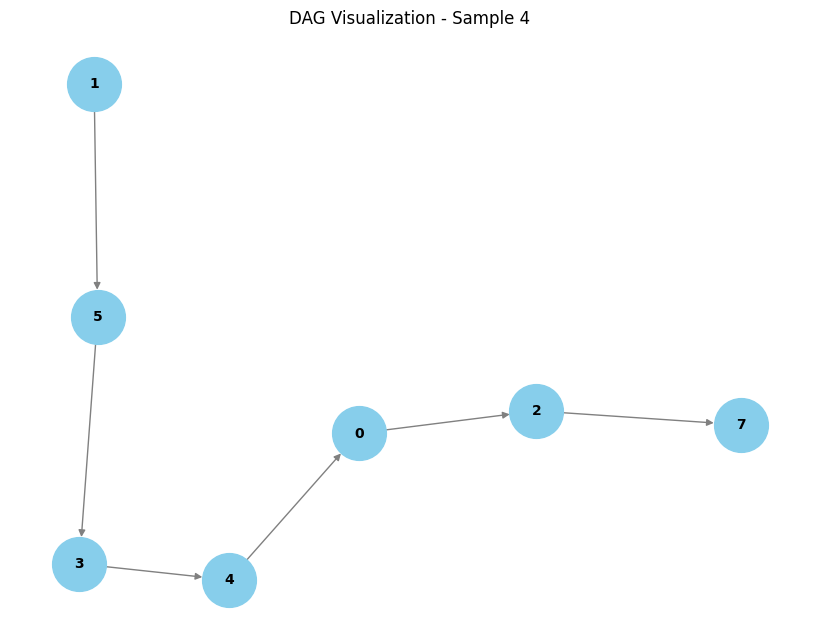

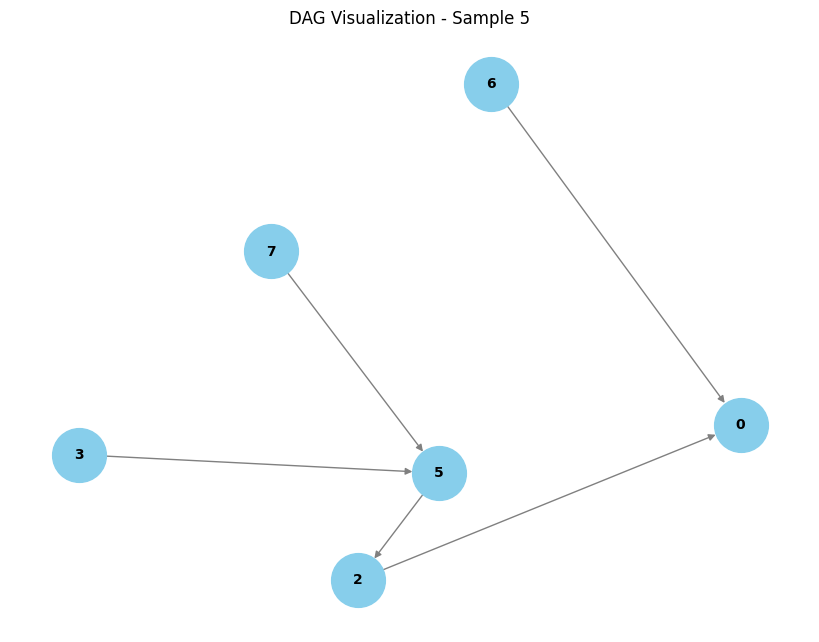

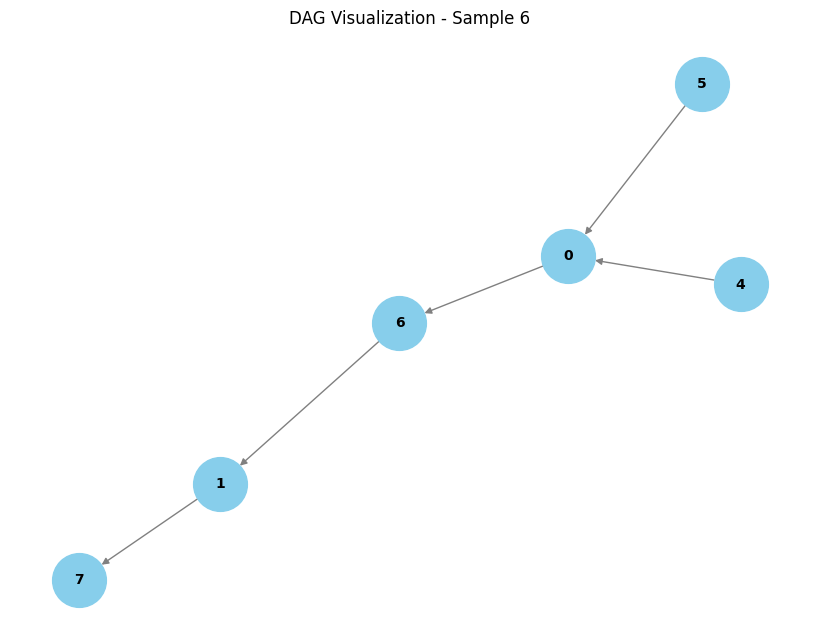

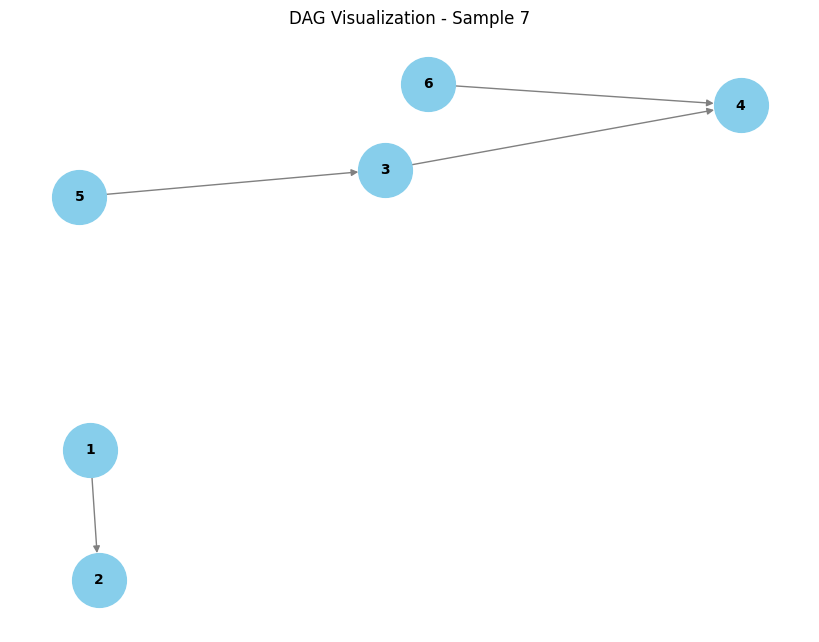

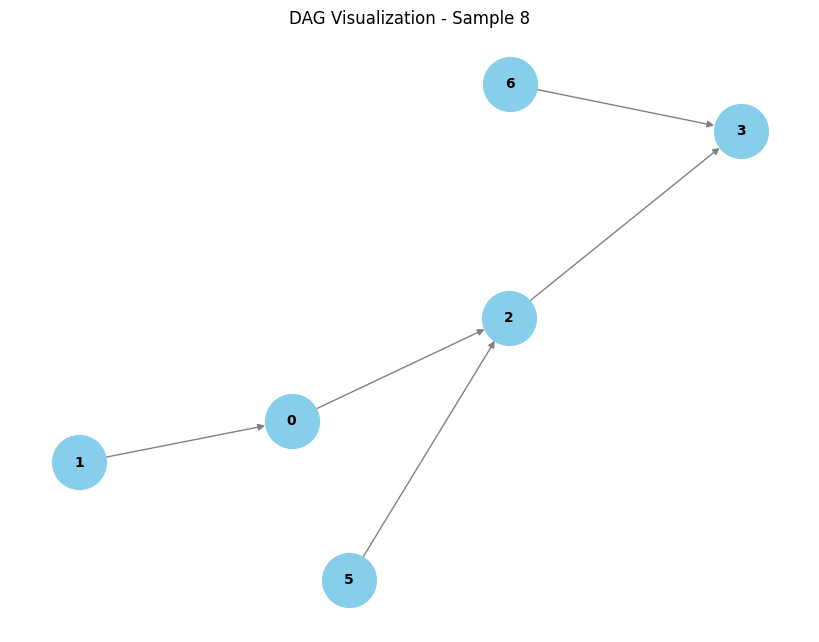

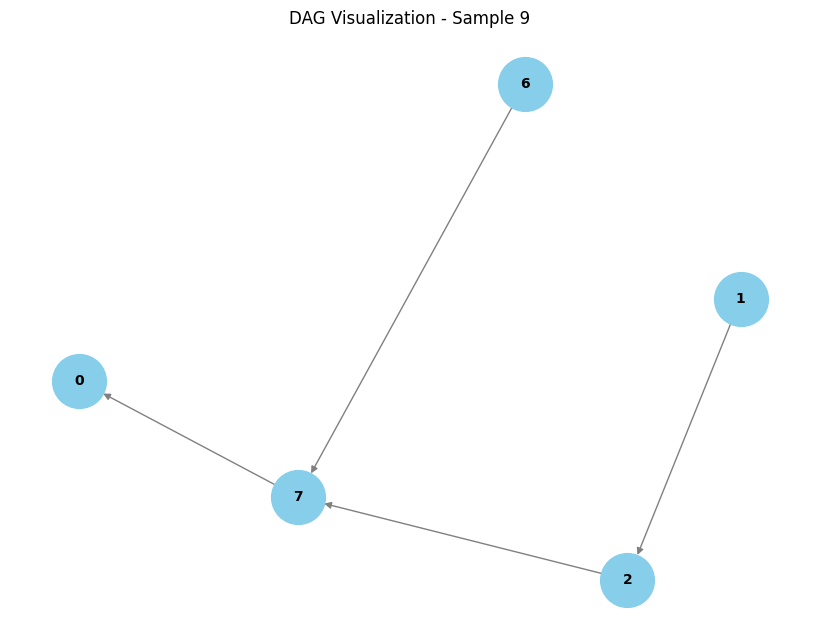

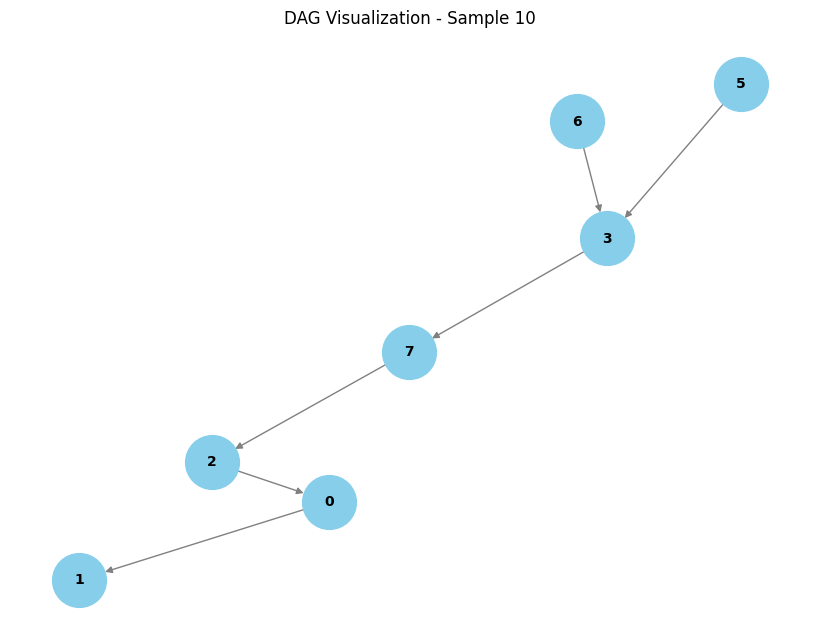

0 <- {}, 1 <- {2}, 2 <- {7}, 3 <- {}, 4 <- {3}, 5 <- {2}, 6 <- {}, 7 <- {0}
0 <- {1}, 1 <- {}, 2 <- {7}, 3 <- {5}, 4 <- {}, 5 <- {2}, 6 <- {}, 7 <- {0}
0 <- {2}, 1 <- {2}, 2 <- {}, 3 <- {6}, 4 <- {}, 5 <- {3}, 6 <- {}, 7 <- {}
0 <- {2}, 1 <- {5}, 2 <- {7}, 3 <- {4}, 4 <- {0}, 5 <- {3}, 6 <- {}, 7 <- {}
0 <- {}, 1 <- {}, 2 <- {0}, 3 <- {5}, 4 <- {}, 5 <- {2}, 6 <- {0}, 7 <- {5}
0 <- {6}, 1 <- {7}, 2 <- {}, 3 <- {}, 4 <- {0}, 5 <- {0}, 6 <- {1}, 7 <- {}
0 <- {}, 1 <- {2}, 2 <- {}, 3 <- {4}, 4 <- {}, 5 <- {3}, 6 <- {4}, 7 <- {}
0 <- {2}, 1 <- {0}, 2 <- {3}, 3 <- {}, 4 <- {}, 5 <- {2}, 6 <- {3}, 7 <- {}
0 <- {}, 1 <- {2}, 2 <- {7}, 3 <- {}, 4 <- {}, 5 <- {}, 6 <- {7}, 7 <- {0}
0 <- {1}, 1 <- {}, 2 <- {0}, 3 <- {7}, 4 <- {}, 5 <- {3}, 6 <- {3}, 7 <- {2}
Sampled DAGs: [[0, 4, 128, 0, 8, 4, 0, 1], [2, 0, 128, 32, 0, 4, 0, 1], [4, 4, 0, 64, 0, 8, 0, 0], [4, 32, 128, 16, 1, 8, 0, 0], [0, 0, 1, 32, 0, 4, 1, 32], [64, 128, 0, 0, 1, 1, 2, 0], [0, 4, 0, 16, 0, 8, 16, 0], [4, 1, 8, 0, 0, 4, 8, 0], [

In [22]:
import sys
import os

# Get the directory of the current notebook or script
current_dir = os.getcwd()

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

# Import the function
from modular_dag_sampling_master.nonsymmetric_sampler import py_calculate_hat_weights





# Assume py_run_nonsymmetric_sampler is correctly set up in nonsymmetric_sampler.pyx

from nonsymmetric_sampler import py_run_nonsymmetric_sampler
import re
def parse_jkl_scores(file_path, max_rows=8):
    """Parses the JKL scores file to extract up to max_rows scores, formatted as a list of lists."""
    scores = []
    with open(file_path, 'r') as file:
        for line in file:
            # Stop if we've reached the desired number of rows
            if len(scores) >= max_rows:
                break

            # Skip lines that do not start with a numeric score (e.g., metadata lines)
            if not re.match(r"^-?\d+\.\d+", line.strip()):
                continue

            parts = line.strip().split()
            try:
                # The first part of each valid line is the score
                score = float(parts[0])
                scores.append([score])  # Wrap in a list for compatibility
            except ValueError as e:
                print(f"Warning: Could not convert line to float: {line.strip()} - {e}")
    return scores

# Use the function and print results for debugging
jkl_scores = parse_jkl_scores('scores.jkl')
#print("Parsed JKL scores (as list of lists):", jkl_scores)  # Verify the format before passing to the sampler

import logging
from logging.handlers import RotatingFileHandler
from nonsymmetric_sampler import py_run_nonsymmetric_sampler

# Configure the logger
log_file = "sampler.log"
max_log_size = 5 * 1024 * 1024  # 5 MB limit for log file size
backup_count = 3  # Keep up to 3 backup files

logger = logging.getLogger("NonsymmetricSamplerLogger")
logger.setLevel(logging.INFO)
handler = RotatingFileHandler(log_file, maxBytes=max_log_size, backupCount=backup_count)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Run the sampler with the logger
dag_size = len(jkl_scores)
num_samples = 10
sampled_dags = py_run_nonsymmetric_sampler(dag_size, num_samples, logger)
print("Sampled DAGs:", sampled_dags)




### Heuristics
Top : Select a K-set C i so as to maximize the posterior probability that pa(i) ⊆ C i (cf. Prop. 2) in the article 

top selects the top parent sets for each node according to their BDeu scores until the number of candidate parents reaches the defined maximum

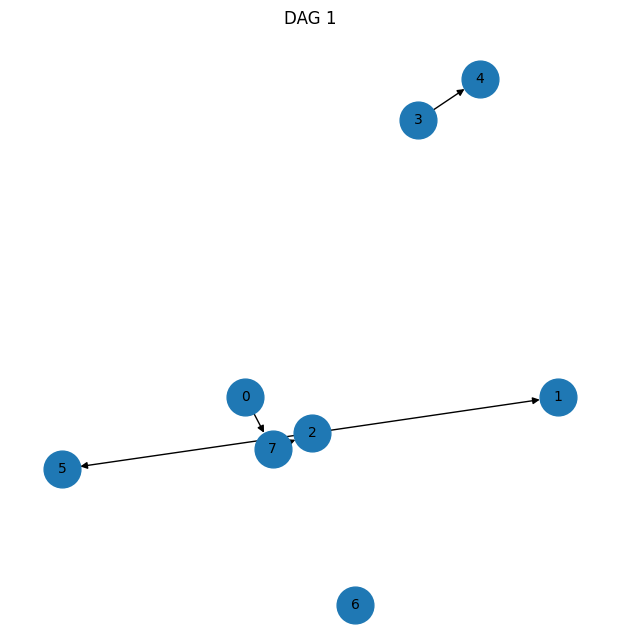

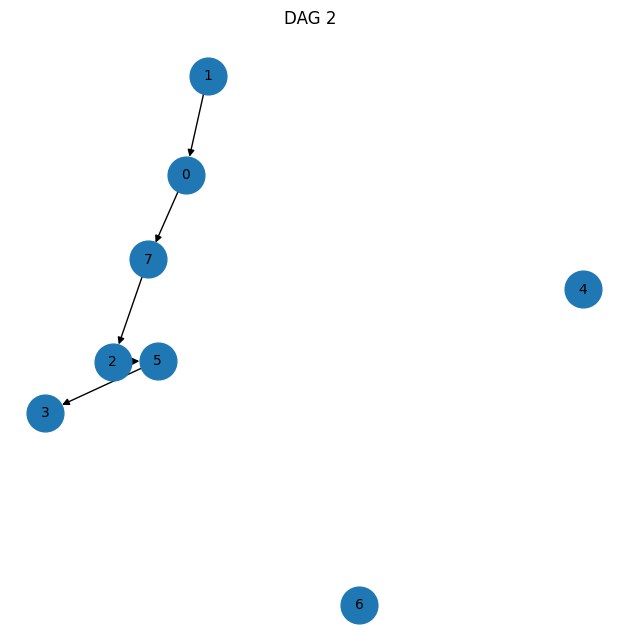

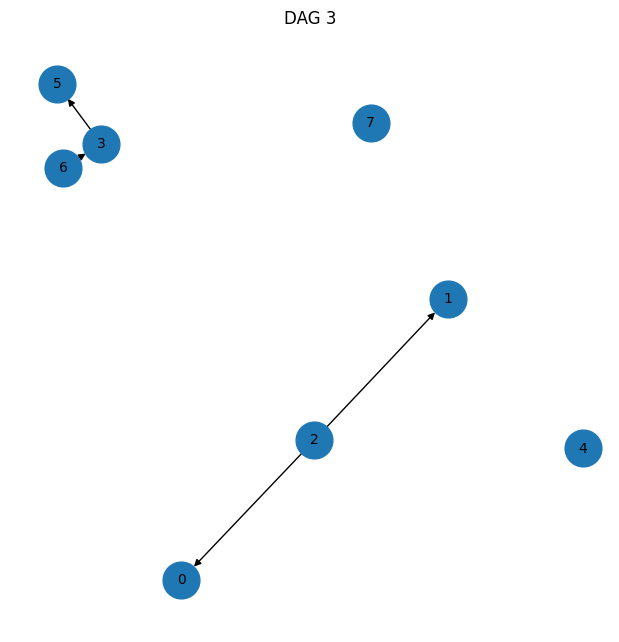

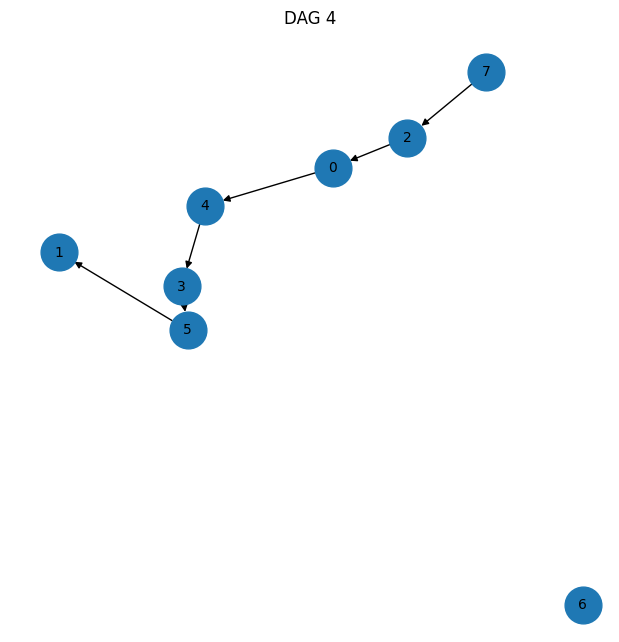

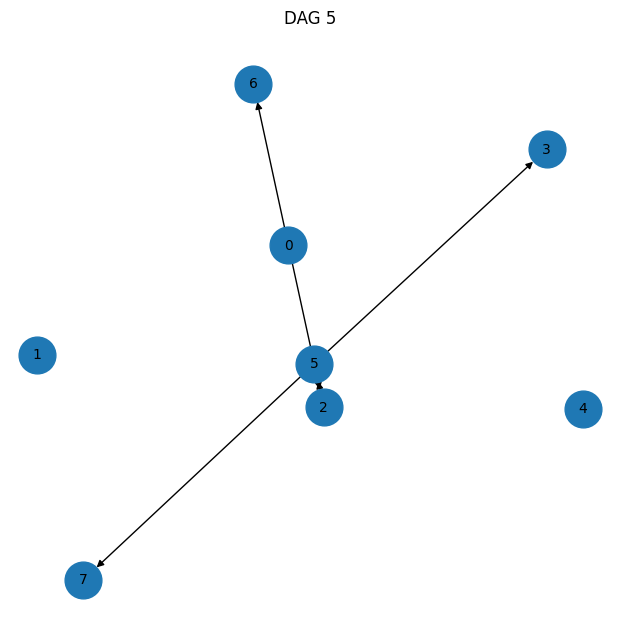

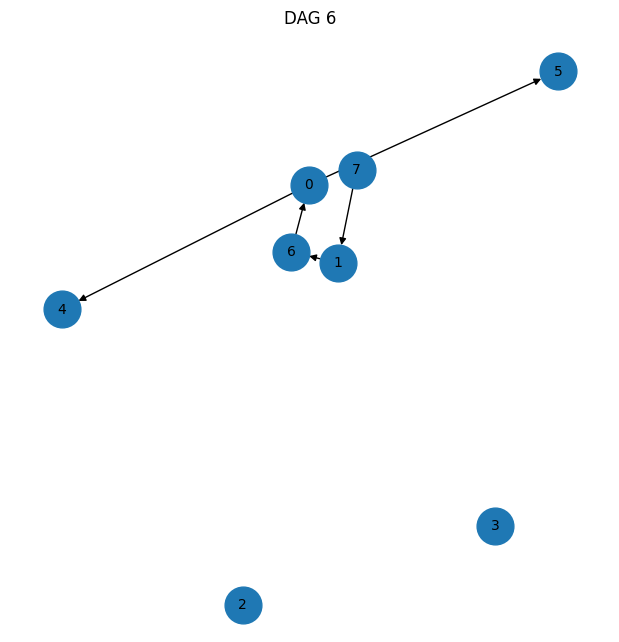

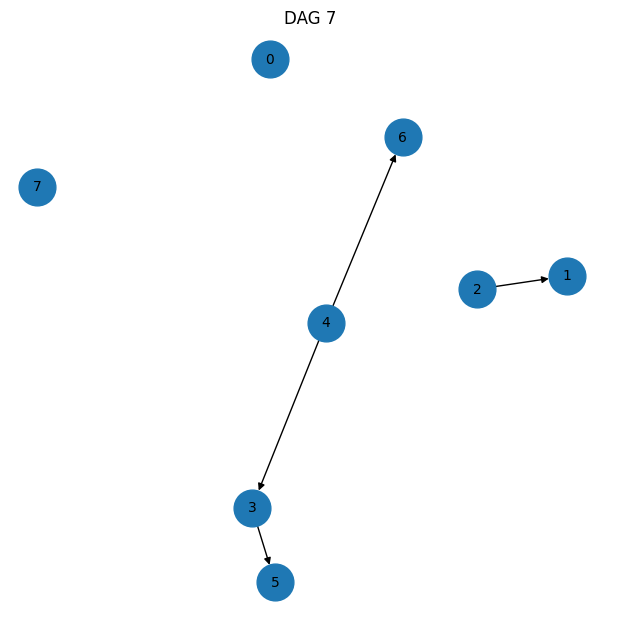

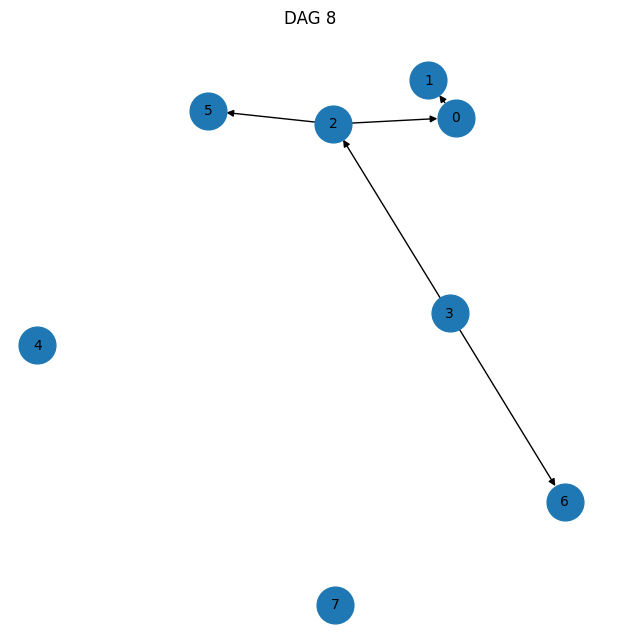

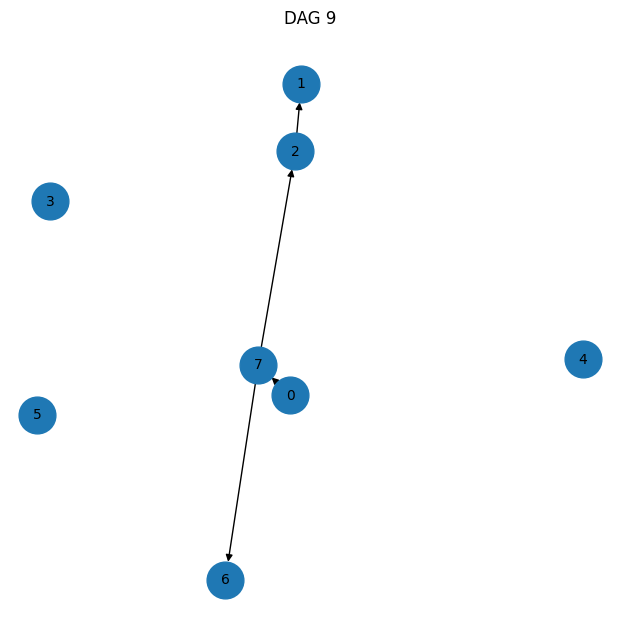

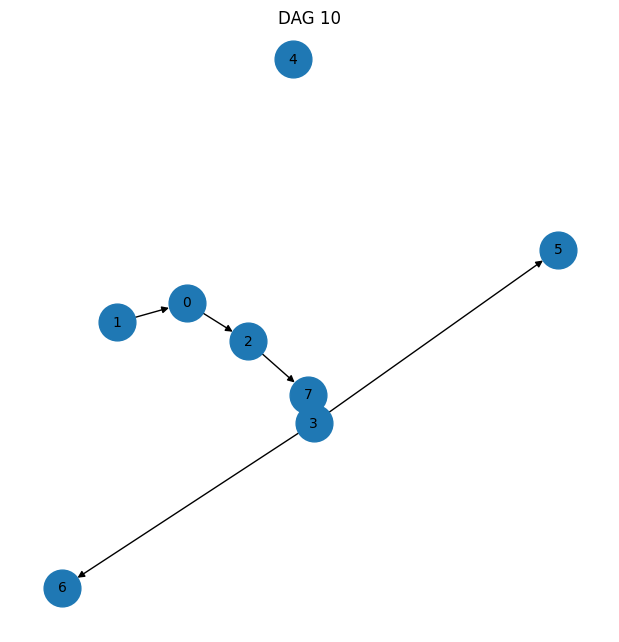

[<networkx.classes.digraph.DiGraph object at 0x7f352cca3b10>, <networkx.classes.digraph.DiGraph object at 0x7f352f217bd0>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9d010>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9c490>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9ef10>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9e610>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9f510>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9f590>, <networkx.classes.digraph.DiGraph object at 0x7f352ce38210>, <networkx.classes.digraph.DiGraph object at 0x7f352ce9e790>]


In [23]:


def convert_bitmask_dag_to_nx(dag_bitmask):
    G = nx.DiGraph()
    size = len(dag_bitmask)
    G.add_nodes_from(range(size))
    
    # Iterate over each child node and its associated bitmask
    for child_node, bitmask in enumerate(dag_bitmask):
        for parent_node in range(size):
            # Check if the parent_node is a parent of child_node
            if bitmask & (1 << parent_node):
                G.add_edge(parent_node, child_node)  # Add the directed edge
    return G

dag_graphs = [convert_bitmask_dag_to_nx(dag_bitmask) for dag_bitmask in sampled_dags]
for i, dag in enumerate(dag_graphs):
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(dag)  # Use a layout for better visualization
    nx.draw(dag, pos, with_labels=True, node_size=700, font_size=10, arrows=True)
    plt.title(f"DAG {i+1}")
    plt.show()
print(dag_graphs)


In [47]:
def parse_gobnilp_jkl(file_path):
    """
    Parse the Gobnilp .jkl file format.

    Args:
    - file_path (str): Path to the .jkl file.

    Returns:
    - dict: Dictionary where keys are the number of parents and values are tuples of (score, parent_nodes).
    """
    scores = {}
    current_node = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue  # Skip empty lines

            parts = line.split()
            if len(parts) == 1 and parts[0].isdigit():
                # Metadata line (e.g., "8"), skip it
                continue
            elif len(parts) == 2 and not line.startswith("-"):
                # Node header line (e.g., "6 64")
                try:
                    current_node = int(parts[0])  # Node ID
                    scores[current_node] = []  # Initialize an empty list for this node
                except ValueError:
                    print(f"Unexpected node header: {line}")
            elif current_node is not None and len(parts) >= 2:
                # Score line, handle it
                try:
                    score = float(parts[0])  # First part is the score
                    num_parents = int(parts[1])  # Second part is the number of parents
                    parent_nodes = tuple(map(int, parts[2:])) if num_parents > 0 else ()
                    scores[current_node].append((score, parent_nodes))
                except ValueError:
                    print(f"Invalid score or parent set line: {line}")
            else:
                print(f"Unrecognized line: {line}")

    return scores






# Use the parser
parsed_scores = parse_gobnilp_jkl('scores.jkl' )

# Display a sample of the parsed data


In [75]:
def select_top_k_parents(scores, k):
    """
    Select the top-K parent sets based on local scores.
    Args:
    - scores: Dictionary of parent set scores for a node.
    - k: Number of top parents to select.

    Returns:
    - List of selected parents.
    """
    sorted_scores = sorted(scores, key=lambda x: x[0])  # Sort by score (ascending)
    return sorted_scores[:k] 

sets=select_top_k_parents(parsed_scores[0], 2)


sets



[(-4594.92287604115, (3, 5, 6)), (-4594.885643618436, (3, 4, 6))]

### evaluation

In [41]:
from itertools import permutations, combinations

# Enumerate all possible edges between 8 nodes
nodes = [0, 1, 2,3,4,5,6,7]


# All possible directed edges (a -> b and b -> a are different)
all_edges = [(i, j) for i in nodes for j in nodes if i != j]

# Function to check if a given set of edges forms a DAG
def is_dag(edges, nodes):
    visited = set()
    stack = set()

    def visit(node):
        if node in stack:
            return False  # Cycle detected
        if node in visited:
            return True  # Already checked this node
        stack.add(node)
        visited.add(node)
        for src, dst in edges:
            if src == node:
                if not visit(dst):
                    return False
        stack.remove(node)
        return True

    return all(visit(node) for node in nodes if node not in visited)

# Generate all subsets of edges and check for DAG property
all_dags = []
for r in range(len(all_edges) + 1):
    for subset in combinations(all_edges, r):
        if is_dag(subset, nodes):
            all_dags.append(subset)

print(f"Total DAGs: {len(all_dags)}")


KeyboardInterrupt: 

my naive method

In [ ]:

dag_edges = [list(permutations(edges, len(edges))) for edges in all_edges]
all_dags = [e for e in dag_edges if is_dag(e)]

print(f"Total DAGs: {len(all_dags)}")
from scipy.stats import norm



# Compute conditional probabilities for each node and parent set
def compute_local_score(data, node, parents):
    # Count occurrences of parent configurations and node outcomes
    parent_configurations = {tuple(row[p] for p in parents): 0 for row in data}
    for row in data:
        parent_tuple = tuple(row[p] for p in parents)
        parent_configurations[parent_tuple] += 1
    # Compute likelihood
    likelihood = 1
    for parent_tuple, count in parent_configurations.items():
        prob = count / len(data)  # Estimate P(node | parents)
        likelihood *= prob
    return likelihood


def compute_global_score(data, dag):
    score = 1
    for node, parents in dag.items():
        score *= compute_local_score(data, node, parents)
    return score


total_dags = len(all_dags)
P_D = sum(compute_global_score(df, dag) for dag in all_dags) / total_dags

# Compute posterior probability
P_D_given_G = compute_global_score(data, dag)
posterior = P_D_given_G / P_D

print(f"Posterior Probability of DAG: {posterior:.4f}")





# **Evaluating a Directed Acyclic Graph (DAG) Compared to All Possible DAGs**

When working with Bayesian Networks, it is often necessary to evaluate how well a given DAG explains the observed data. This involves comparing the likelihood of the data under the specified DAG against all possible DAGs. Below, we outline the theoretical steps and formulas.

---

## **Step 1: Enumerate All Possible DAGs**

For $N$ nodes, the total number of possible DAGs is given by:

$$
T(N) = \prod_{k=1}^{N} (2^{k-1})
$$

Each DAG corresponds to a subset of all possible directed edges such that no cycles are formed.

---

## **Step 2: Compute Local Scores**

The probability of the data for a single node $D_i$, given its parent set $\Pi_i$, is computed as:

$$
P(D_i \mid \Pi_i)
$$

This depends on the local structure of the DAG. Common methods to estimate this include:

- **Maximum Likelihood Estimation (MLE)**: Based on empirical frequencies from the dataset.
- **Bayesian Estimation**: Incorporates priors on the conditional probabilities.

For binary variables, the limited parent configurations simplify the computation.

---

## **Step 3: Compute Global Scores**

For a DAG $G$, the joint probability of the data $D$ under $G$ is:

$$
P(D \mid G) = \prod_{i=1}^{N} P(D_i \mid \Pi_i)
$$

This global score combines the local scores for all nodes in the DAG.

---

## **Step 4: Sum Over All Possible DAGs**

To normalize, we compute the probability of the data $P(D)$ by summing over all possible DAGs:

$$
P(D) = \sum_{G'} P(D \mid G') P(G')
$$

Assuming a uniform prior $P(G')$ over all DAGs:

$$
P(D) = \frac{1}{\text{Number of DAGs}} \sum_{G'} P(D \mid G')
$$

---

## **Step 5: Compute Posterior Probability of Your DAG**

The posterior probability of your DAG $G$ is given by Bayes' Rule:

$$
P(G \mid D) = \frac{P(D \mid G) P(G)}{P(D)}
$$

With a uniform prior $P(G)$:

$$
P(G \mid D) = \frac{P(D \mid G)}{P(D)}
$$

---

## **Summary of Formulas**

1. **Local Score**:
   $$
   P(D_i \mid \Pi_i)
   $$

2. **Global Score**:
   $$
   P(D \mid G) = \prod_{i=1}^{N} P(D_i \mid \Pi_i)
   $$

3. **Data Probability**:
   $$
   P(D) = \frac{1}{\text{Number of DAGs}} \sum_{G'} P(D \mid G')
   $$

4. **Posterior Probability**:
   $$
   P(G \mid D) = \frac{P(D \mid G)}{P(D)}
   $$



 “Exact Bayesian structure discovery in Bayesian networks” (2004),


---

## **2. Steps to Evaluate  Network**

### **Step 1: Compute the Likelihood of D AG**

The likelihood of your guessed DAG $G_{\text{guess}}$ is:
$$
P(D \mid G_{\text{guess}}) = \prod_{i=1}^{N} P(D_i \mid \Pi_i)
$$

Where:
- $D_i$ is the data for node $i$.
- $\Pi_i$ is the parent set of node $i$ in $G_{\text{guess}}$.

For binary data, this likelihood is computed using observed frequencies or a Bayesian score. 

---

### **Step 2: Compute the Denominator ($P(D)$)**

The denominator $P(D)$ sums over all possible DAGs:

$$
P(D) = \sum_{G'} P(D \mid G') P(G')
$$

Usingdynamic programming method, you can compute this efficiently without enumerating all DAGs. 

---

### **Step 3: Compute the Posterior Probability of Your DAG**

Using Bayes' Rule, compute:

$$
P(G_{\text{guess}} \mid D) = \frac{P(D \mid G_{\text{guess}})}{P(D)}
$$






In [45]:
import itertools
import numpy as np
import networkx as nx
from collections import defaultdict

# Example dataset: Binary data with 8 variables
# 100 samples, 8 binary variables
data=df
num_nodes = data.shape[1]
print(num_nodes)
nodes = list(range(num_nodes))






8


log(P(D | G)): 38.58557539392579
log(P(D)): 72.739056806729
P(G | D): 1.4700478953159832e-15
log(P(D | G)): 37.88593530245266
log(P(D)): 72.739056806729
P(G | D): 7.302669626985971e-16
